In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

In [2]:
CLUSTER_NAME: str = 'NGC 2506'

In [3]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [4]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [5]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [6]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [7]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (230.5694282, 9.93815998)
 (pm_l_cosb, pm_b) in mas / yr
    (-4.67475711, -0.24582711)>

# Plain DBSCAN

In [8]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_best_params.json', 'r') as f:
    best_params = json.load(f)

In [9]:
best_params

{'best_value': 1.4501988463593518,
 'best_params': {'eps': 0.1496627559024981, 'min_samples': 19}}

In [10]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.1, 2, False)

Classified into 3210 labels.
Clustered: 1035/1148
1035/1148 sources from literature clustered
1690 clustered sources.


In [ ]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(10):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.1, 2, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 1752 labels.
Clustered: 914/1148
914/1148 sources from literature clustered
1208 clustered sources.
Classified into 1709 labels.
Clustered: 912/1148
912/1148 sources from literature clustered
1207 clustered sources.
Classified into 1759 labels.
Clustered: 904/1148
904/1148 sources from literature clustered
1203 clustered sources.
Classified into 1773 labels.
Clustered: 895/1148
895/1148 sources from literature clustered
1161 clustered sources.
Classified into 1798 labels.
Clustered: 908/1148
908/1148 sources from literature clustered
1177 clustered sources.


In [15]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

2452

In [37]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])

In [40]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])

In [18]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
24692,1636148068921376768,Gaia DR3 573215337576748032,573215337576748032,1211540435,2016.0,12.75807,0.683163,83.831284,0.738135,0.439317,...,0.743907,0.4669,0.276241,0.178231,0.707528,0.178769,8.364347,4.31998,0.193433,12
27629,1636148068921376768,Gaia DR3 573331031112965248,573331031112965248,373313069,2016.0,16.344492,0.27147,84.271933,0.255174,0.645406,...,0.822213,0.516048,0.305319,0.196993,2.279002,0.137678,8.230153,1.017172,0.13146,12
27945,1636148068921376768,Gaia DR3 573343327602348928,573343327602348928,1653900238,2016.0,16.251303,0.161993,84.523919,0.159452,0.413402,...,0.704754,0.442327,0.261702,0.168851,1.434931,0.052641,6.751232,0.914656,0.022381,12
28215,1636148068921376768,Gaia DR3 573354670612121088,573354670612121088,1494711348,2016.0,12.852203,0.035797,84.583456,0.034287,0.567896,...,0.430683,0.270311,0.159929,0.103187,0.828158,0.006719,5.087452,0.154759,0.008961,12
28291,1636148068921376768,Gaia DR3 573357419389008512,573357419389008512,1111982674,2016.0,14.492859,0.240622,84.622989,0.202919,0.43451,...,0.548142,0.344032,0.203546,0.131328,0.676147,0.105221,7.408975,1.28022,-0.051055,12


In [25]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [43]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/20.0

In [46]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/20.0

In [28]:
clustered['occurences'] = occurences/20.0
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences
24692,1636148068921376768,Gaia DR3 573215337576748032,573215337576748032,1211540435,2016.0,12.75807,0.683163,83.831284,0.738135,0.439317,...,0.4669,0.276241,0.178231,0.707528,0.178769,8.364347,4.31998,0.193433,12,0.05
27629,1636148068921376768,Gaia DR3 573331031112965248,573331031112965248,373313069,2016.0,16.344492,0.27147,84.271933,0.255174,0.645406,...,0.516048,0.305319,0.196993,2.279002,0.137678,8.230153,1.017172,0.13146,12,0.05
27945,1636148068921376768,Gaia DR3 573343327602348928,573343327602348928,1653900238,2016.0,16.251303,0.161993,84.523919,0.159452,0.413402,...,0.442327,0.261702,0.168851,1.434931,0.052641,6.751232,0.914656,0.022381,12,0.05
28215,1636148068921376768,Gaia DR3 573354670612121088,573354670612121088,1494711348,2016.0,12.852203,0.035797,84.583456,0.034287,0.567896,...,0.270311,0.159929,0.103187,0.828158,0.006719,5.087452,0.154759,0.008961,12,0.60
28291,1636148068921376768,Gaia DR3 573357419389008512,573357419389008512,1111982674,2016.0,14.492859,0.240622,84.622989,0.202919,0.43451,...,0.344032,0.203546,0.131328,0.676147,0.105221,7.408975,1.28022,-0.051055,12,0.25


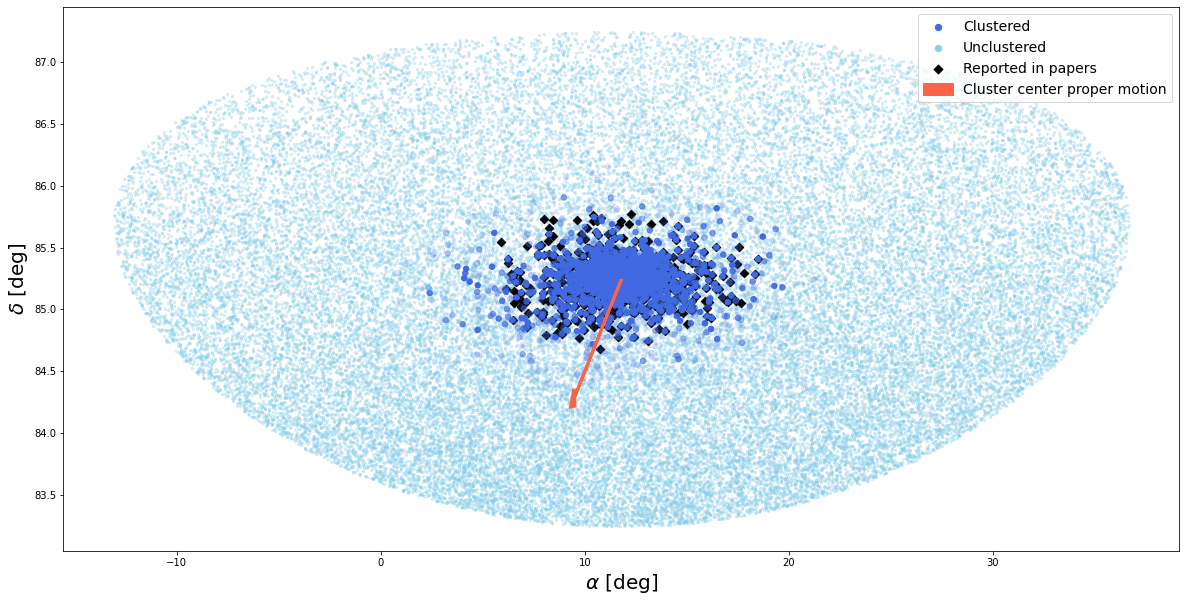

In [36]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='tomato',
          head_width=0.15,
          head_length=0.2,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

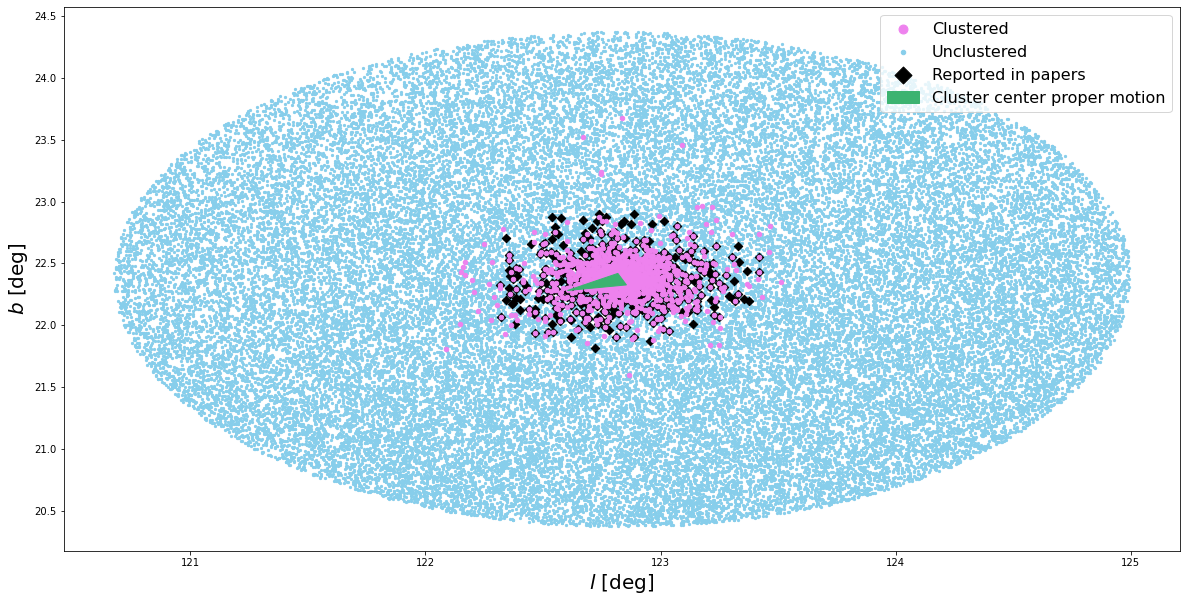

In [12]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.to(u.deg/u.yr).value,
          galactic_coords.pm_b.to(u.deg/u.yr).value,
          linewidth=1.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.25,
          zorder=4,
          label='Cluster center proper motion')
plt.legend(fontsize=16, loc='upper right', markerscale=2.);

In [47]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


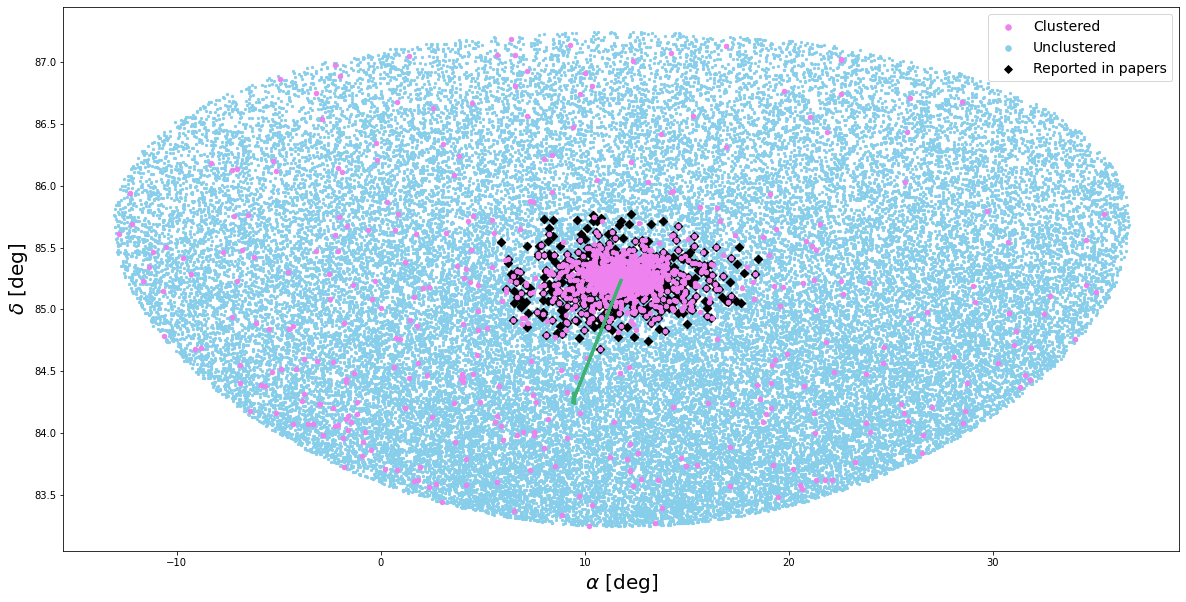

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

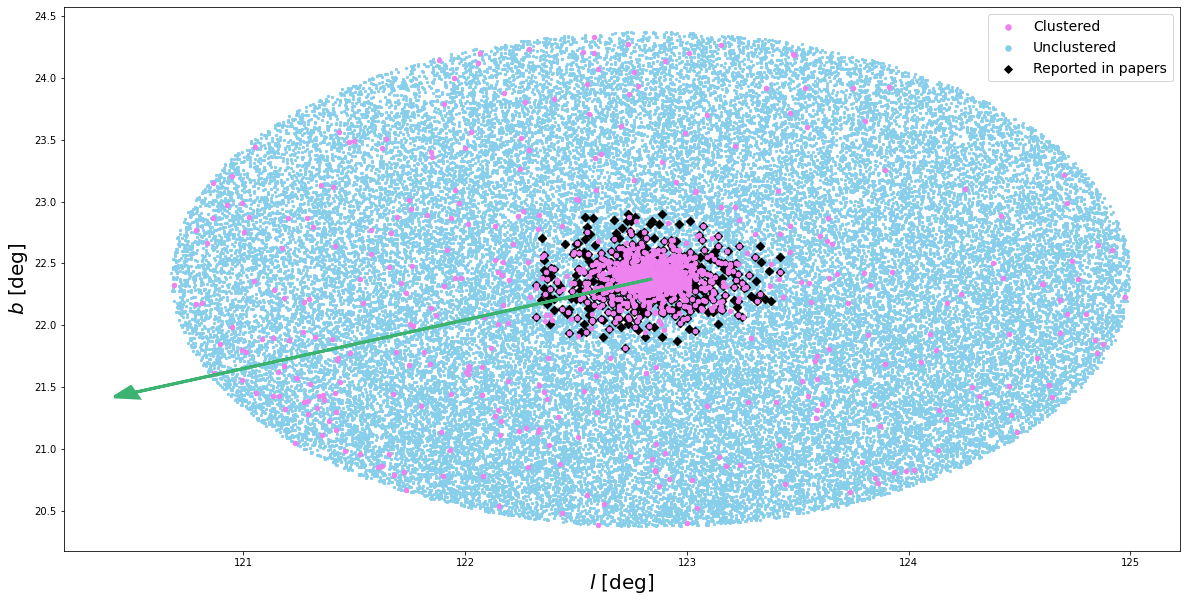

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();